### Written by  [Gabriel Borges Pinheiro](https://www.github.com/gabrielbopi)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def db(X):
    return 10 * np.log10(np.abs(X))
def inv_db(X):
    return 10**(X/10)
def dbm(X):
    return 10 * np.log10(np.abs(X)/(1e-3))
def inv_dbm(X):
    return (1e-3) * 10**(X/10)

def NminInd(list_orig, N):
    """Find N minimum elements"""
    list1 = np.copy(list_orig)
    final_list =[];
  
    for i in range(0, N):   
        minInd = np.argmin(list1)
        final_list.append(minInd)
        list1[minInd] = 99999
        
    return final_list

In [ ]:
def bases(D, x, y, z_med=15):
    num_x = int(x/D)
    num_y = int(y/D)
    total = num_x*num_y
    n = np.array([])
    for i in range(num_y):
        for j in range(num_x):
#             n = np.append(n, np.array([(j*D)+(D/2),(i*D)+(D/2),z_med]))
            n = np.append(n, np.array([(j*D),(i*D),z_med])) 
    return n.reshape(total,3) , total

def usuário(n, x, y, z_med = 1.5,os_x=0,os_y=0):
    UE = np.array([])
    for i in range(n):
        UE = np.append(UE,np.array([x*np.random.random()+os_x,y*np.random.random()+os_y,z_med]))
    return UE.reshape(n,3)

def steeringVector(N,d,λ,sweep_θ=180):
    """sweep_θ: Num pts de θ (Azimute)"""
    n = np.arange(N)
    sweep_θ = 180 #Num pts de θ
    v = np.zeros([sweep_θ,N],dtype='complex')
    for i in range(sweep_θ):
        θ = np.pi*i/180
        v[i] = np.exp(-1j*2*np.pi*(d/λ)*n*np.sin(θ))
    return v

def trilat_lls(D, BS, N_bs=3):
    import math
    
    r_est = np.zeros([n_ue,2])
    for j in range(n_ue):
    # for j in range(N_bs):
    #New denotations
        lista = NminInd(D[j,:], N_bs)
        d = D[j,lista]
        x = BS[lista,0]
        y = BS[lista,1]

        A = np.array([])
        c = np.array([])
        for i in np.arange(N_bs-1):
            for k in np.arange(i+1,N_bs):
                A = np.append(A,[2*(x[i]-x[k]),2*(y[i]-y[k])])
                c = np.append(c,(d[k]**2-d[i]**2)+(-x[k]**2-y[k]**2+x[i]**2+y[i]**2))
        A = A.reshape(math.comb(N_bs,2),2)
        r_est[j] = np.linalg.pinv(A)@c
    return r_est

def trilat_nls(D, BS, r_0, N_bs=3, n_it=15):
    θ = r_0
    theta = np.zeros([n_ue,2])
    lista_min = np.zeros([n_ue,N_bs],dtype='int')
    for j in range(n_ue):
        #New denotations
        lista_min[j] = NminInd(D[j,:], N_bs)
    for a in range(n_it):
        for j in range(n_ue):
        #New denotations
#             lista_min = NminInd(D[j,:], N_bs)
            r = D[j,lista_min[j]]
            x = BS[lista_min[j],0]
            y = BS[lista_min[j],1]
            r_bs = np.array([x,y]).transpose()

            H = np.array([])
            f_θ = np.array([])
            for i in np.arange(N_bs):
                H = np.append(H,(r_bs[i]-θ[j])*1/np.linalg.norm(r_bs[i]-θ[j]))
                f_θ = np.append(f_θ,np.linalg.norm(r_bs[i]-θ[j]))
            H = H.reshape(N_bs,2)
            theta[j] = θ[j] - np.linalg.pinv(H)@(r-f_θ)
        θ = theta
    return theta
Nbins = 40
def cdf(F,bins=Nbins):
    hist, bins = np.histogram(F, bins)
    pdf = hist/np.sum(hist)
    cdf = np.cumsum(pdf)
    return cdf, pdf, bins

## Análises de desempenho

In [ ]:
def loadChannel(mc,par,n_ue,path):
    from os.path import join
    config = loadmat(join(path,'config.mat'))
    H_q = loadmat(join(path,'channel.mat'))
    H_qf = np.squeeze(H_q['Hfreq']) #Matrix of the generated channels with dimensions (mc, n_tx, n_rx, n_f, n_ue, n_bs)
    Hdelay = np.squeeze(H_q['cluster_delay'])
    n_bs = np.size(H_qf[0], axis=3)
    n_f = par['nSubcarr']
    #multi APs
    n_tx = par['array']['Mtx']*par['array']['Ntx'] #TX array
    n_rx = par['array']['Mrx']*par['array']['Nrx'] #RX array

    H_mc = np.zeros([mc,n_ue,n_bs,n_rx,n_f],dtype='complex')
    delay_real = np.zeros([mc,n_ue,n_bs])
    for l in range(mc):    
        for j in range(n_bs):
            for m in range(n_rx):
                for n in range(n_tx):
                    for i in range(n_f):
                        for k in range(n_ue):
                            H_mc[l,k,j,m,i] =  H_qf[l][m,n,i,j]
                            delay_real[l,k,j] = Hdelay[l][k,j]
    return H_mc,delay_real


def calcDist(H,delay_real,n_bs,n_ue,N,n_f,P,Δf,ruido_dbm,N_bs=4, NLS=False):
#     print(H.shape)
    # S(f) generated as a digital randomic diagonal matrix with NRZ coding (amplitude 1 or -1)
    D = np.random.randint(low=0,high=2,size=n_f)*2-1
    S = np.zeros([n_bs,n_f,n_f])
    S[::] = np.diag(D)*np.sqrt(P) #For each AP
    S_inv = np.zeros([n_bs,n_f,n_f])
    #Noise
    var_ruido = inv_dbm(ruido_dbm)*Δf/2
    Y = np.zeros([n_bs,n_f])
    R = np.zeros([n_bs,n_f])
    h = np.zeros([n_ue,n_bs,N,n_f], dtype='complex')
    for k in range(n_ue):
        for j in range(n_bs):
            for n in range(N):
                η = np.random.normal(0,np.sqrt(var_ruido),size=n_f)+1j*np.random.normal(0,np.sqrt(var_ruido),size=n_f)
                # Received signal Y(f)
                Y = H[k,j,n] @ S[j] + η
                S_inv[j] = np.linalg.inv(S[j])
                R =  Y@S_inv[j]
                # Vector of delays
                h[k,j,n] = np.fft.ifft(R)
    #Sample rate
    fs = n_f*Δf
    Ts = 1/fs
    t = np.linspace(0,n_f-1,n_f)*Ts
    c = 3e8 #m/s
    τ_est = np.zeros([n_ue,n_bs],dtype='float64')
    D_est = np.zeros_like(τ_est)
    for k in range(n_ue):
        i_τ = np.apply_along_axis(lambda i:np.argmax(np.abs(i)), 2, h[k])
        τ_est[k] = np.apply_along_axis(lambda k:t[k], 0, i_τ[:,0])
    
    D_est = τ_est*c
    D_est_mc[l] = D_est
    τ = delay_real
    D = τ*c
    #Erro de distancia BS_UEest (metros)
    erro_D = np.abs(D-D_est)
    #Erro de distancia UEreal_estimado (metros)
    r_estl = trilat_lls(D_est, BS, N_bs)
    if (NLS==True):
        r_estn = trilat_nls(D_est, BS, r_0=r_estl, N_bs=N_bs, n_it=15)
        return r_estl,r_estn,D_est,D
    else:
        return r_estl,D_est,D

def cdf_erro(r_est_mc,UE,hist=True):
    n_ue = np.size(UE,axis=1); mc = np.size(r_est_mc,axis=0)
    erro_range_mc = np.zeros([mc])
    for l,r_est in enumerate(r_est_mc):
        UE_l = UE[l]
        erro_range = np.zeros(n_ue)
        for n in range(n_ue):
            erro_range[n] = np.linalg.norm(UE_l[n,:2]-r_est[n])
        erro_range_med = np.sum(erro_range)/n_ue
        erro_range_mc[l] = erro_range_med
    if (hist == True):
        cdf_erro, pdf_erro, bins = cdf(erro_range_mc,bins=Nbins)
        
    perc90 = np.percentile(erro_range_mc,90)
    if (hist == False):
        return perc90
    else:
        return cdf_erro,pdf_erro,bins,perc90

#### Only 1 antenna

In [5]:
from scipy.io import savemat,loadmat

mc = 400
ruido_dbm = -127#dBm
n_ue = 1
#Carrier frequency
f0 = 5.8e9 #Hz
#User band
Δf = 120e3 #Hz
#Numero de portadoras (OFDM)
n_f = 600
#Spectral density of noise
N0=-127#dBm
N_bs = 4 #No of nearest BSs for computing distances on multilateration
# #Array de antenas transmissoras e receptoras (mxn)
Mtx = 1; Ntx = 1;
Mrx = 1; Nrx = 1;
gap_bs = 10 #[m] Espaçamento entre cada BS 
MT_height = 1;
#Lados da area de bases (quadrado com bases a cada gap_bs metros)
BS,n_bs = bases(gap_bs, 40, 20,3)
UE = np.zeros([mc,n_ue,3])
# P_db = np.array([15,20,30]); nPot = len(P_db)
P_db = np.array([19,25,30]); nPot = len(P_db)
perc90l = np.zeros(nPot); perc90n = np.zeros_like(perc90l)#90 percentiles
#CDF values for plotting
cdf_errol=np.zeros([nPot,Nbins]); pdf_errol=np.zeros_like(cdf_errol); binsl=np.zeros([nPot,Nbins+1])
cdf_erron=np.zeros_like(cdf_errol); pdf_erron=np.zeros_like(cdf_errol); binsn=np.zeros_like(binsl);
#multi APs
n_tx = Mtx*Ntx #TX array
n_rx = Mrx*Nrx #RX array
c = 3e8
λmin = c/(f0+Δf*n_f/2)
d = λmin/2

#Generating UEs for each MC realization
for l in range(mc):
    np.random.seed(l)
    UE[l] = usuário(n_ue, 40, 10,z_med=MT_height)
par = {'fc':f0, 'nSubcarr':n_f, 'freqSubcarr':Δf,'BS':BS, 'UE':UE, 'array':{'d':d,'Mtx':Mtx,'Ntx':Ntx,'Mrx':Mrx,'Nrx':Nrx}}
savemat("./models/mc/parameters.mat",par)
# !!!
# It works only for Windows.
#For another OS, you must run the script manually ('.\scripts\genChannelModel_mc.m')
# ! .\octave_windows\mingw64\bin\octave-cli .\scripts\genChannelModel_mc.m
H_mc,delay_real = loadChannel(mc,par,n_ue,path='./models/mc/')

for i,p_db in enumerate(P_db):
    P = inv_dbm(p_db)/n_f
    erro_range_mc = np.zeros([mc])
    r_estl_mc = np.zeros([mc,n_ue,2],dtype='float64'); r_estn_mc = np.zeros([mc,n_ue,2],dtype='float64')
    D_est_mc = np.zeros([mc,n_ue,n_bs],dtype='float64')
    for l in range(mc):
        UE_l = UE[l]
        H = H_mc[l]
        np.random.seed(l)      
        r_l,r_n,D_est,D = calcDist(H,delay_real,n_bs,n_ue,n_rx,n_f,P,Δf,ruido_dbm,N_bs=N_bs,NLS=True)
        #Erro de distancia BS_UEest (metros)
        erro_D = np.abs(D-D_est)
        #Erro de raio UEest_real (metros)        
        r_estl_mc[l] = r_l; r_estn_mc[l] = r_n
    cdf_errol[i],pdf_errol[i],binsl[i],perc90l[i] = cdf_erro(r_estl_mc,UE)  
    cdf_erron[i],pdf_erron[i],binsn[i],perc90n[i] = cdf_erro(r_estn_mc,UE)

#PLOTs
#LLS
print('LLS\n 90-percentile for {}dBm, respectively:'.format(P_db)); print('{}m'.format(perc90l))
plt.figure(figsize=(11,4))
for p_db,i in zip(P_db,range(nPot)):
    label = ('P={}dBm'.format(np.trunc(p_db))) 
    plt.plot(binsl[i,1:],cdf_errol[i], label=label)
plt.ylabel("CDF"); plt.xlabel("Erro de localização [m]"); plt.yticks([0.2,0.37,0.55,0.75,0.9])
plt.xlim(np.min(binsl),np.min([np.max(binsl),35]))
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('LLS c/ {} antena'.format(n_rx)); plt.grid(linestyle='--')
#NLS
print('NLS\n 90-percentile for {}dBm, respectively:'.format(P_db)); print('{}m'.format(perc90n))
plt.figure(figsize=(11,4))
for p_db,i in zip(P_db,range(nPot)):
    label = ('P={}dBm'.format(p_db)) 
    plt.plot(binsn[i,1:],cdf_erron[i], label=label)
plt.ylabel("CDF"); plt.xlabel("Erro de localização [m]")
plt.yticks([0.2,0.37,0.55,0.75,0.9]); plt.xlim(np.min(binsn),np.min([np.max(binsn),35]))
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('NLS c/ {} antena'.format(n_rx)); plt.grid(linestyle='--')

KeyboardInterrupt: 

SNR:

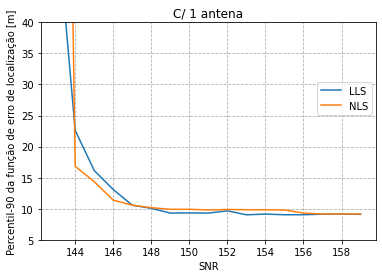

In [7]:
##SNR
from scipy.io import savemat,loadmat

# # mc = 400
# ruido_dbm = -127#dBm
# n_ue = 1
# #Carrier frequency
# f0 = 5.8e9 #Hz
# #User band
# Δf = 120e3 #Hz
# #Numero de portadoras (OFDM)
# # n_f = 600
# # p_db = 100 #dBm
# #Spectral density of noise
# # N0=-127#dBm
# N_bs = 4 #No of nearest BSs for computing distances on multilateration
# # #Array de antenas transmissoras e receptoras (mxn)
# Mtx = 1; Ntx = 1;
# Mrx = 1; Nrx = 1;
# gap_bs = 10 #[m] Espaçamento entre cada BS 
# MT_height = 1;
# #Lados da area de bases (quadrado com bases a cada gap_bs metros)
# BS,n_bs = bases(gap_bs, 40, 20,3)
# # UE = np.zeros([mc,n_ue,3])
SNR = np.arange(143,160,1); nPot = len(SNR)
perc90l = np.zeros(nPot); perc90n = np.zeros_like(perc90l)#90 percentiles
#CDF values for plotting
cdf_errol=np.zeros([nPot,Nbins]); pdf_errol=np.zeros_like(cdf_errol); binsl=np.zeros([nPot,Nbins+1])
cdf_erron=np.zeros_like(cdf_errol); pdf_erron=np.zeros_like(cdf_errol); binsn=np.zeros_like(binsl);
#multi APs
n_tx = Mtx*Ntx #TX array
n_rx = Mrx*Nrx #RX array
c = 3e8
λmin = c/(f0+Δf*n_f/2)
d = λmin/2

# #Generating UEs for each MC realization
# for l in range(mc):
#     np.random.seed(l)
#     UE[l] = usuário(n_ue, 40, 10,z_med=MT_height)
# par = {'fc':f0, 'nSubcarr':n_f, 'freqSubcarr':Δf,'BS':BS, 'UE':UE, 'array':{'d':d,'Mtx':Mtx,'Ntx':Ntx,'Mrx':Mrx,'Nrx':Nrx}}
# savemat("./models/mc/parameters.mat",par)
# # !!!
# # It works only for Windows.
# #For another OS, you must run the script manually ('.\scripts\genChannelModel_mc.m')
# ! .\octave_windows\mingw64\bin\octave-cli .\scripts\genChannelModel_mc.m
H_mc,delay_real = loadChannel(mc,par,n_ue,path='./models/mc/')

for i,snr_db in enumerate(SNR):
    p_db = snr_db + ruido_dbm
    P = inv_dbm(p_db)/n_f
    erro_range_mc = np.zeros([mc])
    r_estl_mc = np.zeros([mc,n_ue,2],dtype='float64'); r_estn_mc = np.zeros([mc,n_ue,2],dtype='float64')
    D_est_mc = np.zeros([mc,n_ue,n_bs],dtype='float64')
    for l in range(mc):
        UE_l = UE[l]
        H = H_mc[l]
        np.random.seed(l)      
        r_l,r_n,D_est,D = calcDist(H,delay_real,n_bs,n_ue,n_rx,n_f,P,Δf,ruido_dbm,N_bs=N_bs,NLS=True)
        #Erro de distancia BS_UEest (metros)
        erro_D = np.abs(D-D_est)
        #Erro de raio UEest_real (metros)        
        r_estl_mc[l] = r_l; r_estn_mc[l] = r_n
    perc90l[i] = cdf_erro(r_estl_mc,UE,hist=False); perc90n[i] = cdf_erro(r_estn_mc,UE,hist=False)

#PLOTs
label = ('LLS'); plt.plot(SNR,perc90l, label=label)
label = ('NLS'); plt.plot(SNR,perc90n, label=label)
plt.ylabel("Percentil-90 da função de erro de localização [m]"); plt.xlabel("SNR");
plt.ylim(top=40,bottom=5)
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('C/ {} antena'.format(n_rx)); plt.grid(linestyle='--')

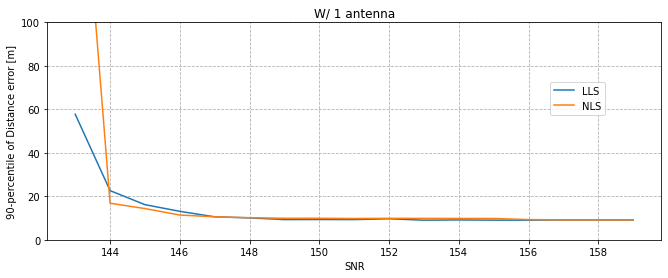

In [8]:
plt.figure(figsize=(11,4))
label = ('LLS'); plt.plot(SNR,perc90l, label=label)
label = ('NLS'); plt.plot(SNR,perc90n, label=label)
plt.ylabel("90-percentile of Distance error [m]"); plt.xlabel("SNR");
plt.ylim(top=100,bottom=0)
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('W/ {} antenna'.format(n_rx)); plt.grid(linestyle='--')

Variar número de portadoras

No subcarriers - 240 done
No subcarriers - 440 done
No subcarriers - 640 done
No subcarriers - 960 done
LLS
 90-percentile for [240 440 640 960] subcarriers, respectively:
[13.02899168 10.05717142 11.25595634  8.50168901]m
NLS
 90-percentile for [240 440 640 960] subcarriers, respectively:
[11.44704142 10.2068807  10.22462642  9.06143294]m


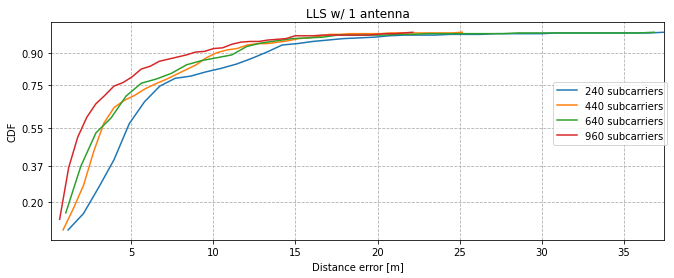

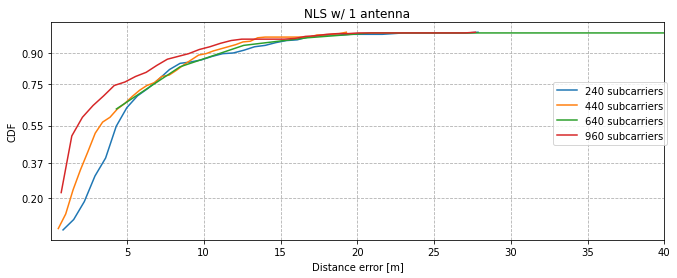

In [10]:
from scipy.io import savemat,loadmat

mc = 300
p_db = 30#dBm
ruido_dbm = -127#dBm
n_ue = 1
#Carrier frequency
f0 = 5.8e9 #Hz
#User band
Δf = 120e3 #Hz
#Numero de portadoras (OFDM)
# n_f = 600
N_f = 20*np.array([12,22,32,48]); nSC = len(N_f)
#Spectral density of noise
N0=-127#dBm
N_bs = 4 #No of nearest BSs for computing distances on multilateration
#Array de antenas transmissoras e receptoras (mxn)
Mtx = 1; Ntx = 1;
Mrx = 1; Nrx = 1;
gap_bs = 10 #[m] Espaçamento entre cada BS 
MT_height = 1;

#Lados da area de bases (quadrado com bases a cada gap_bs metros)
BS,n_bs = bases(gap_bs, 40, 20,3)
UE = np.zeros([mc,n_ue,3])
perc90l = np.zeros(nSC); perc90n = np.zeros(nSC);#90 percentiles
#CDF values for plotting
cdf_errol=np.zeros([nSC,Nbins]); pdf_errol=np.zeros_like(cdf_errol); binsl=np.zeros([nSC,Nbins+1])
cdf_erron=np.zeros_like(cdf_errol); pdf_erron=np.zeros_like(cdf_errol); binsn=np.zeros_like(binsl);
#multi APs
n_tx = Mtx*Ntx #TX array
n_rx = Mrx*Nrx #RX array
c = 3e8

for i,n_f in enumerate(N_f):
    λmin = c/(f0+Δf*n_f/2)
    d = λmin/2
    #Generating UEs for each MC realization
    for l in range(mc):
        np.random.seed(l)
        UE[l] = usuário(n_ue, 40, 10,z_med=MT_height)
    par = {'fc':f0, 'nSubcarr':n_f, 'freqSubcarr':Δf,'BS':BS, 'UE':UE, 'array':{'d':d,'Mtx':Mtx,'Ntx':Ntx,'Mrx':Mrx,'Nrx':Nrx}}
    savemat("./models/mc/parameters.mat",par)
    # !!! It works only for Windows.
    #For another OS, you must run the script manually ('.\scripts\genChannelModel_mc.m')
    ! .\octave_windows\mingw64\bin\octave-cli .\scripts\genChannelModel_mc.m
    H_mc,delay_real = loadChannel(mc,par,n_ue,path='./models/mc/')
    P = inv_dbm(p_db)/n_f
    erro_range_mc = np.zeros([mc])
    r_estl_mc = np.zeros([mc,n_ue,2],dtype='float64'); r_estn_mc = np.zeros([mc,n_ue,2],dtype='float64')
    D_est_mc = np.zeros([mc,n_ue,n_bs],dtype='float64')
    for l in range(mc):
        UE_l = UE[l]
        H = H_mc[l]
        np.random.seed(l)      
        r_l,r_n,D_est,D = calcDist(H,delay_real,n_bs,n_ue,n_rx,n_f,P,Δf,ruido_dbm,N_bs=N_bs,NLS=True)
        #Erro de distancia BS_UEest (metros)
        erro_D = np.abs(D-D_est)
        #Erro de raio UEest_real (metros)        
        r_estl_mc[l] = r_l; r_estn_mc[l] = r_n
    print('No subcarriers - {} done'.format(n_f))
    cdf_errol[i],pdf_errol[i],binsl[i],perc90l[i] = cdf_erro(r_estl_mc,UE)
    cdf_erron[i],pdf_erron[i],binsn[i],perc90n[i] = cdf_erro(r_estn_mc,UE)
    
    
for f0 in N_f:
    f = f0 + Δf*(np.arange(n_f)-n_f/2) #Hz
    #Compute CDF
    for j in range(mc):
        np.random.seed(j)
        UE = usuário(n_ue, 200, 100)
        erro_D[j] = erro_distancia(BS,UE,f,Δf,p_db)
    erro_Dtot = erro_D.reshape([n_bs*mc])
    cdf_erroi, pdf_erroi, binsi = cdf(erro_Dtot,bins=21)
    cdf_erro = np.concatenate([cdf_erro,cdf_erroi])
    pdf_erro = np.concatenate([pdf_erro,pdf_erroi])
    bins = np.concatenate([bins,binsi])
cdf_erro = cdf_erro.reshape([len(N_f),np.size(cdf_erroi)])
pdf_erro = pdf_erro.reshape([(len(N_f)),np.size(pdf_erroi)])
bins = bins.reshape([(len(N_f)),np.size(binsi)])
    
#PLOTs
#LLS
print('LLS\n 90-percentile for {} subcarriers, respectively:'.format(N_f)); print('{}m'.format(perc90l))
plt.figure(figsize=(11,4))
for i,n_f in enumerate(N_f):
    label = ('{} subcarriers'.format(n_f)) 
    plt.plot(binsl[i,1:],cdf_errol[i], label=label)
plt.ylabel("CDF"); plt.xlabel("Distance error [m]"); plt.yticks([0.2,0.37,0.55,0.75,0.9])
plt.xlim(np.min(binsl),np.min([np.max(binsl),40]))
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('LLS w/ {} antenna'.format(n_rx)); plt.grid(linestyle='--')
#NLS
print('NLS\n 90-percentile for {} subcarriers, respectively:'.format(N_f)); print('{}m'.format(perc90n))
plt.figure(figsize=(11,4))
for i,n_f in enumerate(N_f):
    label = ('{} subcarriers'.format(n_f)) 
    plt.plot(binsn[i,1:],cdf_erron[i], label=label)
plt.ylabel("CDF"); plt.xlabel("Distance error [m]")
plt.yticks([0.2,0.37,0.55,0.75,0.9]); plt.xlim(np.min(binsn),np.min([np.max(binsn),40]))
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('NLS w/ {} antenna'.format(n_rx)); plt.grid(linestyle='--')

## W/ Beamforming filtering

In [ ]:
def loadChannel(mc,par,n_ue,path):
    from os.path import join
    config = loadmat(join(path,'config.mat'))
    H_q = loadmat(join(path,'channel.mat'))
    H_qf = np.squeeze(H_q['Hfreq']) #Matrix of the generated channels with dimensions (mc, n_tx, n_rx, n_f, n_ue, n_bs)
    Hdelay = np.squeeze(H_q['cluster_delay'])
    n_bs = np.size(H_qf[0], axis=3)
    n_f = par['nSubcarr']
    #multi APs
    n_tx = par['array']['Mtx']*par['array']['Ntx'] #TX array
    n_rx = par['array']['Mrx']*par['array']['Nrx'] #RX array

    H_mc = np.zeros([mc,n_ue,n_bs,n_rx,n_f],dtype='complex')
    delay_real = np.zeros([mc,n_ue,n_bs])
    for l in range(mc):    
        for j in range(n_bs):
            for m in range(n_rx):
                for n in range(n_tx):
                    for i in range(n_f):
                        for k in range(n_ue):
                            H_mc[l,k,j,m,i] =  H_qf[l][m,n,i,j]
                            delay_real[l,k,j] = Hdelay[l][k,j]
    return H_mc,delay_real

In [ ]:
def ins_sig_noise(H,n_bs,n_ue,n_f,P,ruido_dbm=-127):
    """From channel response H(f) and noise η(f), generates a randomic pilot signal S(f) for each BS-UE
    and computes the received signal Y(f) = H(f) * S(f) + η
    It returns (Y,S)
    """
    Y = np.zeros_like(H)
    n_ant = np.size(H,axis=2)
    var_ruido = inv_dbm(ruido_dbm)*Δf/2
    # S(f) generated as a digital randomic diagonal matrix with NRZ coding (amplitude 1 or -1)
    s = np.random.randint(low=0,high=2,size=(n_ue,n_f))*2-1
#     D = np.random.randint(low=0,high=2,size=n_f)*2-1
#     S = np.zeros([n_bs,n_f,n_f])
#     S = np.zeros([n_ue,n_bs,n_f,n_f])
#     S[::] = np.diag(D)*np.sqrt(P) #For each AP
    for k in range(n_ue):
#         S[::] = np.diag(s[k])*np.sqrt(P) #For each AP
        S = np.diag(s[k])*np.sqrt(P) #For each AP
        for j in range(n_bs):
            for i in range(n_ant):
                η = np.random.normal(0,np.sqrt(var_ruido),size=n_f)+1j*np.random.normal(0,np.sqrt(var_ruido),size=n_f)
                # Received signal Y(f)
                Y[k,j,i] = H[k,j,i] @ S + η
    return Y,s

def bf_filter(h,n_bs,n_ue,n_f,v):
    h_bf = np.zeros([n_ue,n_bs,n_f],'complex')
    for k in range(n_ue):
        for j in range(n_bs):
            h_dir = v.conj() @ h[k,j,:,:]
#             ind = np.unravel_index(np.argmax(abs(h_dir), axis=None), h_dir.shape)
            ind = np.argmax(np.sum(np.abs(h_dir)**2,axis=1))
            h_bf[k,j] = h_dir[ind,:]
    return h_bf

def calcDist_bf(Y,s,delay_real,n_bs,n_ue,N,n_f,P,Δf,v,N_bs=4,NLS=False):
    h = np.zeros([n_ue,n_bs,N,n_f], dtype='complex')
    for k in range(n_ue):
        S = np.diag(s[k]) #For each AP
        S_inv = np.linalg.inv(S)
        for j in range(n_bs):
            for i in range(N):
#                 R =  S_inv@Y[k,j,i]
                R =  Y[k,j,i]@S_inv
                # Vector of delays
                h[k,j,i] = np.fft.ifft(R)
    h_bf=bf_filter(h,n_bs,n_ue,n_f,v);
    #Sample rate
    fs = n_f*Δf
    Ts = 1/fs
    t = np.linspace(0,n_f-1,n_f)*Ts
    c = 3e8 #m/s
    τ_est = np.zeros([n_ue,n_bs],dtype='float64')
    D_est = np.zeros_like(τ_est)
    for k in range(n_ue):
        i_τ = np.apply_along_axis(lambda i:np.argmax(np.abs(i)), 1, h_bf[k])
        τ_est[k] = np.apply_along_axis(lambda k:t[k], 0, i_τ)   
    D_est = τ_est*c
    D_est_mc[l] = D_est
    τ = delay_real
    D = τ*c
    #Erro de distancia BS_UEest (metros)
    erro_D = np.abs(D-D_est)
    #Erro de distancia UEreal_estimado (metros)
    r_estl = trilat_lls(D_est, BS, N_bs)
    if (NLS==True):
        r_estn = trilat_nls(D_est, BS, r_0=r_estl, N_bs=N_bs, n_it=15)
        return r_estl,r_estn,D_est,D
    else:
        return r_estl,D_est,D

LLS
 90-percentile for [19 25 30]dBm, respectively:
[9.14458704 8.84464237 8.84464237]m
NLS
 90-percentile for [19 25 30]dBm, respectively:
[10.01843229  9.41930024  9.41930024]m


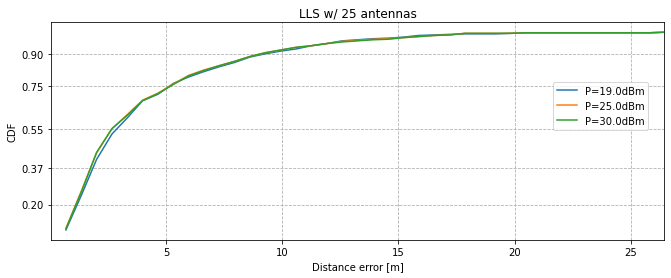

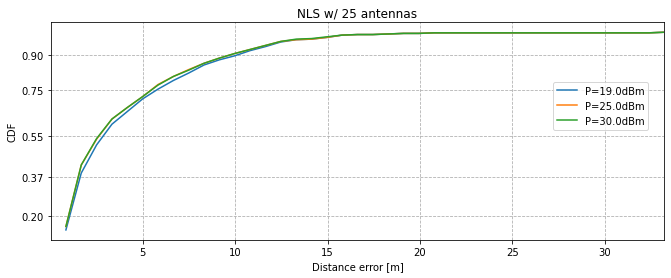

In [17]:
from scipy.io import savemat,loadmat

mc = 400
ruido_dbm = -127#dBm
n_ue = 1
#Carrier frequency
f0 = 5.8e9 #Hz
#User band
Δf = 120e3 #Hz
#Numero de portadoras (OFDM)
n_f = 600
#Spectral density of noise
N0=-127#dBm
N_bs = 4 #No of nearest BSs for computing distances on multilateration
#Array de antenas transmissoras e receptoras (mxn)
Mtx = 1; Ntx = 1;
Mrx = 5; Nrx = 5;
gap_bs = 10 #[m] Espaçamento entre cada BS 
MT_height = 1;
#Lados da area de bases (quadrado com bases a cada gap_bs metros)
BS,n_bs = bases(gap_bs, 40, 20,3)
UE = np.zeros([mc,n_ue,3])
# P_db = np.array([10,15,20]); nPot = len(P_db)
P_db = np.array([19,25,30]); nPot = len(P_db)
perc90l = np.zeros(nPot); perc90n = np.zeros(nPot);#90 percentiles
#CDF values for plotting
cdf_errol=np.zeros([nPot,Nbins]); pdf_errol=np.zeros_like(cdf_errol); binsl=np.zeros([nPot,Nbins+1])
cdf_erron=np.zeros_like(cdf_errol); pdf_erron=np.zeros_like(cdf_errol); binsn=np.zeros_like(binsl);
#multi APs
n_tx = Mtx*Ntx #TX array
n_rx = Mrx*Nrx #RX array
c = 3e8

##
λmin = c/(f0+Δf*n_f/2)
d = λmin/2
v = steeringVector(n_rx,d,λmin,sweep_θ=18)
#Generating UEs for each MC realization
for l in range(mc):
    np.random.seed(l)
    UE[l] = usuário(n_ue, 40, 10,z_med=MT_height)
par = {'fc':f0, 'nSubcarr':n_f, 'freqSubcarr':Δf,'BS':BS, 'UE':UE, 'array':{'d':d,'Mtx':Mtx,'Ntx':Ntx,'Mrx':Mrx,'Nrx':Nrx}}
savemat("./models/mc_bf/parameters.mat",par)
# !!! It works only for Windows.
#For another OS, you must comment the line below and run the script manually ('.\scripts\genChannelModel_mc.m')
# ! .\octave_windows\mingw64\bin\octave-cli .\scripts\genChannelModel_mc_bf.m
H_mc,delay_real = loadChannel(mc,par,n_ue,path='./models/mc_bf/')
Y_mc = np.zeros_like(H_mc)
# Y_bf = np.zeros_like(H_mc[:,:,:,0,:])
s_mc = np.zeros([mc,n_bs,n_f])

#Computing results for each power
for i,p_db in enumerate(P_db):
    P = inv_dbm(p_db)/n_f
    for l in range(mc):
    #     UE_l = UE[l]
        H = H_mc[l]
#         for k in range(n_ue):
#             for j in range(n_bs):
        Y,s = ins_sig_noise(H,n_bs,n_ue,n_f,P,ruido_dbm)
#         Y_bf[l]=bf_filter(Y,n_bs,n_ue,n_f,v);
        s_mc[l] = s; Y_mc[l] = Y
    erro_range_mc = np.zeros([mc])
    r_estl_mc = np.zeros([mc,n_ue,2],dtype='float64'); r_estn_mc = np.zeros([mc,n_ue,2],dtype='float64')
    D_est_mc = np.zeros([mc,n_ue,n_bs],dtype='float64');
    for l in range(mc):
        np.random.seed(l)
        s = s_mc[l]
#         r_l,r_n,D_est,D = calcDist_bf(H_bf[l],delay_real,n_bs,n_ue,n_f,P,Δf,ruido_dbm,N_bs=N_bs,NLS=True)
        r_l,r_n,D_est,D = calcDist_bf(Y_mc[l],s,delay_real,n_bs,n_ue,n_rx,n_f,P,Δf,v,N_bs=N_bs,NLS=True)
        #Erro de distancia BS_UEest (metros)
        erro_D = np.abs(D-D_est)
        #Erro de raio UEest_real (metros)        
        r_estl_mc[l] = r_l; r_estn_mc[l] = r_n
    cdf_errol[i],pdf_errol[i],binsl[i],perc90l[i] = cdf_erro(r_estl_mc,UE)
    cdf_erron[i],pdf_erron[i],binsn[i],perc90n[i] = cdf_erro(r_estn_mc,UE)

#LLS
print('LLS\n 90-percentile for {}dBm, respectively:'.format(P_db)); print('{}m'.format(perc90l))
plt.figure(figsize=(11,4))
for i,p_db in enumerate(P_db):
    label = ('P={}dBm'.format(np.trunc(p_db))) 
    plt.plot(binsl[i,1:],cdf_errol[i], label=label)
plt.ylabel("CDF"); plt.xlabel("Distance error [m]"); plt.yticks([0.2,0.37,0.55,0.75,0.9])
plt.xlim(np.min(binsl),np.min([np.max(binsl),35]))
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('LLS w/ {} antennas'.format(n_rx)); plt.grid(linestyle='--')
#NLS
print('NLS\n 90-percentile for {}dBm, respectively:'.format(P_db)); print('{}m'.format(perc90n))
plt.figure(figsize=(11,4))
for i,p_db in enumerate(P_db):
    label = ('P={}dBm'.format(np.trunc(p_db))) 
    plt.plot(binsn[i,1:],cdf_erron[i], label=label)
plt.ylabel("CDF"); plt.xlabel("Distance error [m]")
plt.yticks([0.2,0.37,0.55,0.75,0.9]); plt.xlim(np.min(binsn),np.min([np.max(binsn),35]))
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('NLS w/ {} antennas'.format(n_rx)); plt.grid(linestyle='--')

LLS
 90-percentile for [19 25 30]dBm, respectively:
[11.70272374 11.70272374 11.70272374]m
NLS
 90-percentile for [19 25 30]dBm, respectively:
[11.49564522 11.49564522 11.49564522]m


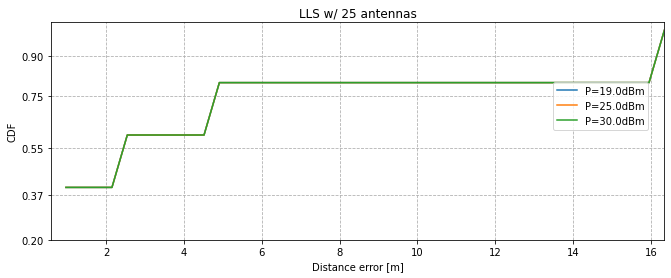

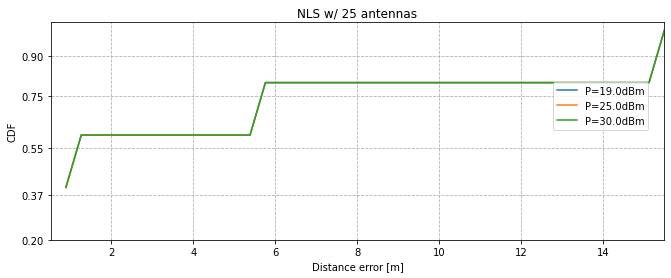

In [30]:
from scipy.io import savemat,loadmat

mc = 5
ruido_dbm = -127#dBm
n_ue = 1
#Carrier frequency
f0 = 5.8e9 #Hz
#User band
Δf = 120e3 #Hz
#Numero de portadoras (OFDM)
n_f = 600
#Spectral density of noise
N0=-127#dBm
N_bs = 4 #No of nearest BSs for computing distances on multilateration
#Array de antenas transmissoras e receptoras (mxn)
Mtx = 1; Ntx = 1;
Mrx = 5; Nrx = 5;
gap_bs = 10 #[m] Espaçamento entre cada BS 
MT_height = 1;
#Lados da area de bases (quadrado com bases a cada gap_bs metros)
BS,n_bs = bases(gap_bs, 40, 20,3)
UE = np.zeros([mc,n_ue,3])
# P_db = np.array([10,15,20]); nPot = len(P_db)
P_db = np.array([19,25,30]); nPot = len(P_db)
perc90l = np.zeros(nPot); perc90n = np.zeros(nPot);#90 percentiles
#CDF values for plotting
cdf_errol=np.zeros([nPot,Nbins]); pdf_errol=np.zeros_like(cdf_errol); binsl=np.zeros([nPot,Nbins+1])
cdf_erron=np.zeros_like(cdf_errol); pdf_erron=np.zeros_like(cdf_errol); binsn=np.zeros_like(binsl);
#multi APs
n_tx = Mtx*Ntx #TX array
n_rx = Mrx*Nrx #RX array
c = 3e8

##
λmin = c/(f0+Δf*n_f/2)
d = λmin/2
v = steeringVector(n_rx,d,λmin,sweep_θ=18)
#Generating UEs for each MC realization
for l in range(mc):
    np.random.seed(l)
    UE[l] = usuário(n_ue, 40, 10,z_med=MT_height)
par = {'fc':f0, 'nSubcarr':n_f, 'freqSubcarr':Δf,'BS':BS, 'UE':UE, 'array':{'d':d,'Mtx':Mtx,'Ntx':Ntx,'Mrx':Mrx,'Nrx':Nrx}}
savemat("./models/mc_bf/parameters.mat",par)
# !!! It works only for Windows.
#For another OS, you must comment the line below and run the script manually ('.\scripts\genChannelModel_mc.m')
# ! .\octave_windows\mingw64\bin\octave-cli .\scripts\genChannelModel_mc_bf.m
H_mc,delay_real = loadChannel(mc,par,n_ue,path='./models/mc_bf/')
Y_mc = np.zeros_like(H_mc)
# Y_bf = np.zeros_like(H_mc[:,:,:,0,:])
s_mc = np.zeros([mc,n_bs,n_f])

#Computing results for each power
for i,p_db in enumerate(P_db):
    P = inv_dbm(p_db)/n_f
    for l in range(mc):
    #     UE_l = UE[l]
        H = H_mc[l]
#         for k in range(n_ue):
#             for j in range(n_bs):
        Y,s = ins_sig_noise(H,n_bs,n_ue,n_f,P,ruido_dbm)
#         Y_bf[l]=bf_filter(Y,n_bs,n_ue,n_f,v);
        s_mc[l] = s; Y_mc[l] = Y
    erro_range_mc = np.zeros([mc])
    r_estl_mc = np.zeros([mc,n_ue,2],dtype='float64'); r_estn_mc = np.zeros([mc,n_ue,2],dtype='float64')
    D_est_mc = np.zeros([mc,n_ue,n_bs],dtype='float64');
    for l in range(mc):
        np.random.seed(l)
        s = s_mc[l]
#         r_l,r_n,D_est,D = calcDist_bf(H_bf[l],delay_real,n_bs,n_ue,n_f,P,Δf,ruido_dbm,N_bs=N_bs,NLS=True)
        r_l,r_n,D_est,D = calcDist_bf(Y_mc[l],s,delay_real,n_bs,n_ue,n_rx,n_f,P,Δf,v,N_bs=N_bs,NLS=True)
        #Erro de distancia BS_UEest (metros)
        erro_D = np.abs(D-D_est)
        #Erro de raio UEest_real (metros)        
        r_estl_mc[l] = r_l; r_estn_mc[l] = r_n
    cdf_errol[i],pdf_errol[i],binsl[i],perc90l[i] = cdf_erro(r_estl_mc,UE)
    cdf_erron[i],pdf_erron[i],binsn[i],perc90n[i] = cdf_erro(r_estn_mc,UE)

#LLS
print('LLS\n 90-percentile for {}dBm, respectively:'.format(P_db)); print('{}m'.format(perc90l))
plt.figure(figsize=(11,4))
for i,p_db in enumerate(P_db):
    label = ('P={}dBm'.format(np.trunc(p_db))) 
    plt.plot(binsl[i,1:],cdf_errol[i], label=label)
plt.ylabel("CDF"); plt.xlabel("Distance error [m]"); plt.yticks([0.2,0.37,0.55,0.75,0.9])
plt.xlim(np.min(binsl),np.min([np.max(binsl),35]))
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('LLS w/ {} antennas'.format(n_rx)); plt.grid(linestyle='--')
#NLS
print('NLS\n 90-percentile for {}dBm, respectively:'.format(P_db)); print('{}m'.format(perc90n))
plt.figure(figsize=(11,4))
for i,p_db in enumerate(P_db):
    label = ('P={}dBm'.format(np.trunc(p_db))) 
    plt.plot(binsn[i,1:],cdf_erron[i], label=label)
plt.ylabel("CDF"); plt.xlabel("Distance error [m]")
plt.yticks([0.2,0.37,0.55,0.75,0.9]); plt.xlim(np.min(binsn),np.min([np.max(binsn),35]))
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('NLS w/ {} antennas'.format(n_rx)); plt.grid(linestyle='--')

130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130


135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135


140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140


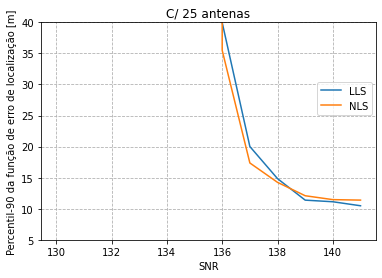

In [10]:
##SNR
from scipy.io import savemat,loadmat

mc = 400
ruido_dbm = -127#dBm
n_ue = 1
#Carrier frequency
f0 = 5.8e9 #Hz
#User band
Δf = 120e3 #Hz
#Numero de portadoras (OFDM)
n_f = 600
p_db = 100 #dBm
#Spectral density of noise
N0=-127#dBm
N_bs = 4 #No of nearest BSs for computing distances on multilateration
#Array de antenas transmissoras e receptoras (mxn)
Mtx = 1; Ntx = 1;
Mrx = 5; Nrx = 5;
gap_bs = 10 #[m] Espaçamento entre cada BS 
MT_height = 1;
#Lados da area de bases (quadrado com bases a cada gap_bs metros)
BS,n_bs = bases(gap_bs, 40, 20,3)
UE = np.zeros([mc,n_ue,3])
SNR = np.arange(130,142,1); nPot = len(SNR)
# SNR = np.arange(143,148,1); nPot = len(SNR)
perc90l = np.zeros(nPot); perc90n = np.zeros_like(perc90l)#90 percentiles
#CDF values for plotting
cdf_errol=np.zeros([nPot,Nbins]); pdf_errol=np.zeros_like(cdf_errol); binsl=np.zeros([nPot,Nbins+1])
cdf_erron=np.zeros_like(cdf_errol); pdf_erron=np.zeros_like(cdf_errol); binsn=np.zeros_like(binsl);
#multi APs
n_tx = Mtx*Ntx #TX array
n_rx = Mrx*Nrx #RX array
c = 3e8
λmin = c/(f0+Δf*n_f/2)
d = λmin/2

v = steeringVector(n_rx,d,λmin,sweep_θ=18)

#Generating UEs for each MC realization
for l in range(mc):
    np.random.seed(l)
    UE[l] = usuário(n_ue, 40, 10,z_med=MT_height)
par = {'fc':f0, 'nSubcarr':n_f, 'freqSubcarr':Δf,'BS':BS, 'UE':UE, 'array':{'d':d,'Mtx':Mtx,'Ntx':Ntx,'Mrx':Mrx,'Nrx':Nrx}}
savemat("./models/mc_bf/parameters.mat",par)
## !!! It works only for Windows.
##For another OS, you must comment the line below and run the script manually ('.\scripts\genChannelModel_mc_bf.m')
# ! .\octave_windows\mingw64\bin\octave-cli .\scripts\genChannelModel_mc_bf.m
H_mc,delay_real = loadChannel(mc,par,n_ue,path='./models/mc_bf/')
Y_mc = np.zeros_like(H_mc)
s_mc = np.zeros([mc,n_ue,n_f])

for i,snr_db in enumerate(SNR):
    p_db = snr_db + ruido_dbm
    P = inv_dbm(p_db)/n_f
    
    for l in range(mc):
        H = H_mc[l]
        Y,s = ins_sig_noise(H,n_bs,n_ue,n_f,P,ruido_dbm)
        s_mc[l] = s; Y_mc[l] = Y

    erro_range_mc = np.zeros([mc])
    r_estl_mc = np.zeros([mc,n_ue,2],dtype='float64'); r_estn_mc = np.zeros([mc,n_ue,2],dtype='float64')
    D_est_mc = np.zeros([mc,n_ue,n_bs],dtype='float64')
    for l in range(mc):
        UE_l = UE[l]
        H = H_mc[l]
        np.random.seed(l)
        s = s_mc[l]
        r_l,r_n,D_est,D = calcDist_bf(Y_mc[l],s,delay_real,n_bs,n_ue,n_rx,n_f,P,Δf,v,N_bs=N_bs,NLS=True)
        
#         r_l,r_n,D_est,D = calcDist(H,delay_real,n_bs,n_ue,n_rx,n_f,P,Δf,ruido_dbm,N_bs=N_bs,NLS=True)
        #Erro de distancia BS_UEest (metros)
        erro_D = np.abs(D-D_est)
        #Erro de raio UEest_real (metros)        
        r_estl_mc[l] = r_l; r_estn_mc[l] = r_n
    print(snr_db)
    perc90l[i] = cdf_erro(r_estl_mc,UE,hist=False); perc90n[i] = cdf_erro(r_estn_mc,UE,hist=False)

#PLOTs
label = ('LLS'); plt.plot(SNR,perc90l, label=label)
label = ('NLS'); plt.plot(SNR,perc90n, label=label)
plt.ylabel("Percentil-90 da função de erro de localização [m]"); plt.xlabel("SNR");
plt.ylim(top=40,bottom=5)
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('C/ {} antenas'.format(n_rx)); plt.grid(linestyle='--')

No subcarriers - 240 done
No subcarriers - 440 done
No subcarriers - 640 done
No subcarriers - 960 done
LLS
 Percentil-90 for [240 440 640 960] sub-portadoras, respectivamente:
[13.28967297  9.77538711  9.72195971 11.75467865]m
NLS
 Percentil-90 for [240 440 640 960] sub-portadoras, respectivamente:
[13.33303007 11.01266509 10.68407722  9.7605856 ]m


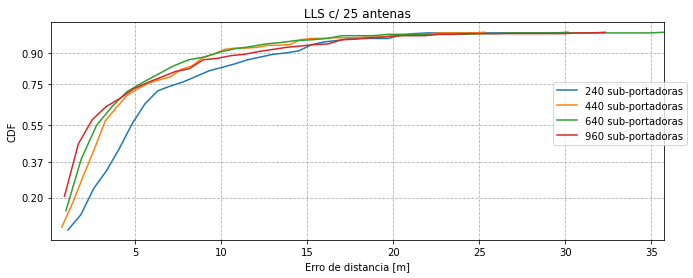

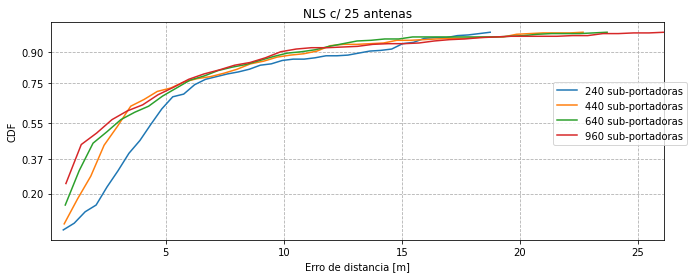

In [26]:
from scipy.io import savemat,loadmat

mc = 300
p_db = 30#dBm
ruido_dbm = -127#dBm
n_ue = 1
#Carrier frequency
f0 = 5.8e9 #Hz
#User band
Δf = 120e3 #Hz
#Numero de portadoras (OFDM)
N_f = 20*np.array([12,22,32,48]); nSC = len(N_f)
# N_f = 20*np.array([32,48]); nSC = len(N_f)

#Spectral density of noise
N0=-127#dBm
N_bs = 4 #No of nearest BSs for computing distances on multilateration
#Array de antenas transmissoras e receptoras (mxn)
Mtx = 1; Ntx = 1;
Mrx = 5; Nrx = 5;
gap_bs = 10 #[m] Espaçamento entre cada BS 
MT_height = 1;
#Lados da area de bases (quadrado com bases a cada gap_bs metros)
BS,n_bs = bases(gap_bs, 40, 20,3)
UE = np.zeros([mc,n_ue,3])
perc90l = np.zeros(nSC); perc90n = np.zeros(nSC);#90 percentiles
#CDF values for plotting
cdf_errol=np.zeros([nSC,Nbins]); pdf_errol=np.zeros_like(cdf_errol); binsl=np.zeros([nSC,Nbins+1])
cdf_erron=np.zeros_like(cdf_errol); pdf_erron=np.zeros_like(cdf_errol); binsn=np.zeros_like(binsl);
#multi APs
n_tx = Mtx*Ntx #TX array
n_rx = Mrx*Nrx #RX array
c = 3e8

for i,n_f in enumerate(N_f):
    λmin = c/(f0+Δf*n_f/2)
    d = λmin/2
    v = steeringVector(n_rx,d,λmin,sweep_θ=18)
    #Generating UEs for each MC realization
    for l in range(mc):
        np.random.seed(l)
        UE[l] = usuário(n_ue, 40, 10,z_med=MT_height)
#     par = {'fc':f0, 'nSubcarr':n_f, 'freqSubcarr':Δf,'BS':BS, 'UE':UE, 'array':{'d':d,'Mtx':Mtx,'Ntx':Ntx,'Mrx':Mrx,'Nrx':Nrx}}
#     savemat("./models/mc/parameters.mat",par)
    par = {'fc':f0, 'nSubcarr':n_f, 'freqSubcarr':Δf,'BS':BS, 'UE':UE, 'array':{'d':d,'Mtx':Mtx,'Ntx':Ntx,'Mrx':Mrx,'Nrx':Nrx}}
    savemat("./models/mc_bf/parameters.mat",par)
    # !!!
    # It works only for Windows.
    #For another OS, you must run the script manually ('.\scripts\genChannelModel_mc_bf.m')
    ! .\octave_windows\mingw64\bin\octave-cli .\scripts\genChannelModel_mc_bf.m
    H_mc,delay_real = loadChannel(mc,par,n_ue,path='./models/mc_bf/')
#     H_bf = np.zeros_like(H_mc[:,:,:,0,:])
    Y_mc = np.zeros_like(H_mc)
    s_mc = np.zeros([mc,n_bs,n_f])
    for l in range(mc):
        H = H_mc[l]
        Y,s = ins_sig_noise(H,n_bs,n_ue,n_f,P,ruido_dbm)
        s_mc[l] = s; Y_mc[l] = Y
#         H_bf[l]=bf_filter(H,n_bs,n_ue,n_f,v)    
    P = inv_dbm(p_db)/n_f
    erro_range_mc = np.zeros([mc])
    r_estl_mc = np.zeros([mc,n_ue,2],dtype='float64'); r_estn_mc = np.zeros([mc,n_ue,2],dtype='float64')
    D_est_mc = np.zeros([mc,n_ue,n_bs],dtype='float64')
    for l in range(mc):
        np.random.seed(l)
        UE_l = UE[l]
        H = H_mc[l]
        s = s_mc[l]
        r_l,r_n,D_est,D = calcDist_bf(Y_mc[l],s,delay_real,n_bs,n_ue,n_rx,n_f,P,Δf,v,N_bs=N_bs,NLS=True)
#         r_l,r_n,D_est,D = calcDist_bf(H_bf[l],delay_real,n_bs,n_ue,n_f,P,Δf,ruido_dbm,N_bs=N_bs,NLS=True)
        #Erro de distancia BS_UEest (metros)
        erro_D = np.abs(D-D_est)
        #Erro de raio UEest_real (metros)        
        r_estl_mc[l] = r_l; r_estn_mc[l] = r_n
    print('No subcarriers - {} done'.format(n_f))
    cdf_errol[i],pdf_errol[i],binsl[i],perc90l[i] = cdf_erro(r_estl_mc,UE)
    cdf_erron[i],pdf_erron[i],binsn[i],perc90n[i] = cdf_erro(r_estn_mc,UE)
#PLOTs
#LLS
print('LLS\n Percentil-90 for {} sub-portadoras, respectivamente:'.format(N_f)); print('{}m'.format(perc90l))
plt.figure(figsize=(11,4))
for i,n_f in enumerate(N_f):
    label = ('{} sub-portadoras'.format(n_f)) 
    plt.plot(binsl[i,1:],cdf_errol[i], label=label)
plt.ylabel("CDF"); plt.xlabel("Erro de distancia [m]"); plt.yticks([0.2,0.37,0.55,0.75,0.9])
plt.xlim(np.min(binsl),np.min([np.max(binsl),40]));
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('LLS c/ {} antenas'.format(n_rx)); plt.grid(linestyle='--')
#NLS
print('NLS\n Percentil-90 for {} sub-portadoras, respectivamente:'.format(N_f)); print('{}m'.format(perc90n))
plt.figure(figsize=(11,4))
for i,n_f in enumerate(N_f):
    label = ('{} sub-portadoras'.format(n_f)) 
    plt.plot(binsn[i,1:],cdf_erron[i], label=label)
plt.ylabel("CDF"); plt.xlabel("Erro de distancia [m]")
plt.yticks([0.2,0.37,0.55,0.75,0.9]); plt.xlim(np.min(binsn),np.min([np.max(binsn),40]))
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('NLS c/ {} antenas'.format(n_rx)); plt.grid(linestyle='--')

60 Antennas

LLS
 90-percentile for [19 25 30]dBm, respectively:
[9.22066829 9.12405885 9.22066829]m
NLS
 90-percentile for [19 25 30]dBm, respectively:
[9.30457109 9.30457109 9.30457109]m


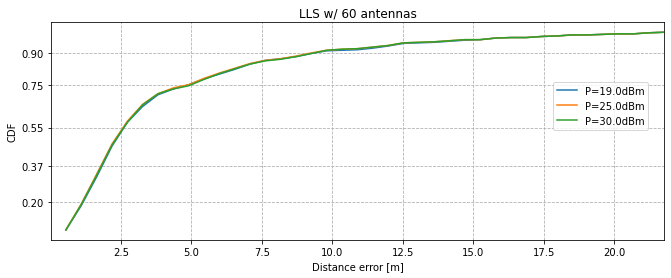

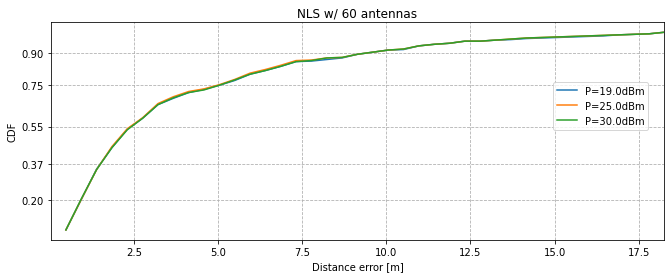

In [16]:
from scipy.io import savemat,loadmat

mc = 400
ruido_dbm = -127#dBm
n_ue = 1
#Carrier frequency
f0 = 5.8e9 #Hz
#User band
Δf = 120e3 #Hz
#Numero de portadoras (OFDM)
n_f = 600
#Spectral density of noise
N0=-127#dBm
N_bs = 4 #No of nearest BSs for computing distances on multilateration
#Array de antenas transmissoras e receptoras (mxn)
Mtx = 1; Ntx = 1;
Mrx = 10; Nrx = 6;
gap_bs = 10 #[m] Espaçamento entre cada BS 
MT_height = 1;
#Lados da area de bases (quadrado com bases a cada gap_bs metros)
BS,n_bs = bases(gap_bs, 40, 20,3)
UE = np.zeros([mc,n_ue,3])
# P_db = np.array([10,15,20]); nPot = len(P_db)
P_db = np.array([19,25,30]); nPot = len(P_db)
perc90l = np.zeros(nPot); perc90n = np.zeros(nPot);#90 percentiles
#CDF values for plotting
cdf_errol=np.zeros([nPot,Nbins]); pdf_errol=np.zeros_like(cdf_errol); binsl=np.zeros([nPot,Nbins+1])
cdf_erron=np.zeros_like(cdf_errol); pdf_erron=np.zeros_like(cdf_errol); binsn=np.zeros_like(binsl);
#multi APs
n_tx = Mtx*Ntx #TX array
n_rx = Mrx*Nrx #RX array
c = 3e8

##
λmin = c/(f0+Δf*n_f/2)
d = λmin/2
v = steeringVector(n_rx,d,λmin,sweep_θ=18)
#Generating UEs for each MC realization
for l in range(mc):
    np.random.seed(l)
    UE[l] = usuário(n_ue, 40, 10,z_med=MT_height)
par = {'fc':f0, 'nSubcarr':n_f, 'freqSubcarr':Δf,'BS':BS, 'UE':UE, 'array':{'d':d,'Mtx':Mtx,'Ntx':Ntx,'Mrx':Mrx,'Nrx':Nrx}}
savemat("./models/mc_bf/parameters.mat",par)
# !!! It works only for Windows.
#For another OS, you must comment the line below and run the script manually ('.\scripts\genChannelModel_mc.m')
# ! .\octave_windows\mingw64\bin\octave-cli .\scripts\genChannelModel_mc_bf.m
H_mc,delay_real = loadChannel(mc,par,n_ue,path='./models/mc_bf/')
Y_mc = np.zeros_like(H_mc)
s_mc = np.zeros([mc,n_bs,n_f])

#Computing results for each power
for i,p_db in enumerate(P_db):
    P = inv_dbm(p_db)/n_f
    for l in range(mc):
    #     UE_l = UE[l]
        H = H_mc[l]
        Y,s = ins_sig_noise(H,n_bs,n_ue,n_f,P,ruido_dbm)
        s_mc[l] = s; Y_mc[l] = Y
    erro_range_mc = np.zeros([mc])
    r_estl_mc = np.zeros([mc,n_ue,2],dtype='float64'); r_estn_mc = np.zeros([mc,n_ue,2],dtype='float64')
    D_est_mc = np.zeros([mc,n_ue,n_bs],dtype='float64');
    for l in range(mc):
        np.random.seed(l)
        s = s_mc[l]
        r_l,r_n,D_est,D = calcDist_bf(Y_mc[l],s,delay_real,n_bs,n_ue,n_rx,n_f,P,Δf,v,N_bs=N_bs,NLS=True)
        #Erro de distancia BS_UEest (metros)
        erro_D = np.abs(D-D_est)
        #Erro de raio UEest_real (metros)        
        r_estl_mc[l] = r_l; r_estn_mc[l] = r_n
    cdf_errol[i],pdf_errol[i],binsl[i],perc90l[i] = cdf_erro(r_estl_mc,UE)
    cdf_erron[i],pdf_erron[i],binsn[i],perc90n[i] = cdf_erro(r_estn_mc,UE)

#LLS
print('LLS\n 90-percentile for {}dBm, respectively:'.format(P_db)); print('{}m'.format(perc90l))
plt.figure(figsize=(11,4))
for i,p_db in enumerate(P_db):
    label = ('P={}dBm'.format(np.trunc(p_db))) 
    plt.plot(binsl[i,1:],cdf_errol[i], label=label)
plt.ylabel("CDF"); plt.xlabel("Distance error [m]"); plt.yticks([0.2,0.37,0.55,0.75,0.9])
plt.xlim(np.min(binsl),np.min([np.max(binsl),35]))
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('LLS w/ {} antennas'.format(n_rx)); plt.grid(linestyle='--')
#NLS
print('NLS\n 90-percentile for {}dBm, respectively:'.format(P_db)); print('{}m'.format(perc90n))
plt.figure(figsize=(11,4))
for i,p_db in enumerate(P_db):
    label = ('P={}dBm'.format(np.trunc(p_db))) 
    plt.plot(binsn[i,1:],cdf_erron[i], label=label)
plt.ylabel("CDF"); plt.xlabel("Distance error [m]")
plt.yticks([0.2,0.37,0.55,0.75,0.9]); plt.xlim(np.min(binsn),np.min([np.max(binsn),35]))
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('NLS w/ {} antennas'.format(n_rx)); plt.grid(linestyle='--')

SNR - 130dBm done
SNR - 131dBm done
SNR - 132dBm done
SNR - 133dBm done
SNR - 134dBm done
SNR - 135dBm done
SNR - 136dBm done
SNR - 137dBm done
SNR - 138dBm done
SNR - 139dBm done


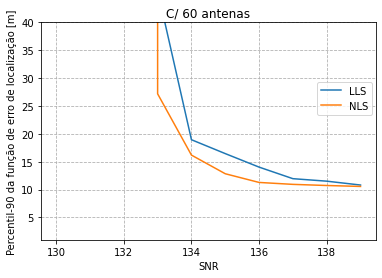

In [19]:
##SNR
from scipy.io import savemat,loadmat

# mc = 400
ruido_dbm = -127#dBm
n_ue = 1
#Carrier frequency
f0 = 5.8e9 #Hz
#User band
Δf = 120e3 #Hz
#Numero de portadoras (OFDM)
n_f = 600
#Spectral density of noise
N0=-127#dBm
N_bs = 4 #No of nearest BSs for computing distances on multilateration
#Array de antenas transmissoras e receptoras (mxn)
Mtx = 1; Ntx = 1;
Mrx = 10; Nrx = 6;
gap_bs = 10 #[m] Espaçamento entre cada BS 
MT_height = 1;
#Lados da area de bases (quadrado com bases a cada gap_bs metros)
BS,n_bs = bases(gap_bs, 40, 20,3)
UE = np.zeros([mc,n_ue,3])
SNR = np.arange(130,140,1); nPot = len(SNR)
perc90l = np.zeros(nPot); perc90n = np.zeros_like(perc90l)#90 percentiles
#CDF values for plotting
cdf_errol=np.zeros([nPot,Nbins]); pdf_errol=np.zeros_like(cdf_errol); binsl=np.zeros([nPot,Nbins+1])
cdf_erron=np.zeros_like(cdf_errol); pdf_erron=np.zeros_like(cdf_errol); binsn=np.zeros_like(binsl);
#multi APs
n_tx = Mtx*Ntx #TX array
n_rx = Mrx*Nrx #RX array
c = 3e8
λmin = c/(f0+Δf*n_f/2)
d = λmin/2

v = steeringVector(n_rx,d,λmin,sweep_θ=18)

#Generating UEs for each MC realization
for l in range(mc):
    np.random.seed(l)
    UE[l] = usuário(n_ue, 40, 10,z_med=MT_height)
# par = {'fc':f0, 'nSubcarr':n_f, 'freqSubcarr':Δf,'BS':BS, 'UE':UE, 'array':{'d':d,'Mtx':Mtx,'Ntx':Ntx,'Mrx':Mrx,'Nrx':Nrx}}
# savemat("./models/mc_bf/parameters.mat",par)
## !!! It works only for Windows.
##For another OS, you must comment the line below and run the script manually ('.\scripts\genChannelModel_mc_bf.m')
# ! .\octave_windows\mingw64\bin\octave-cli .\scripts\genChannelModel_mc_bf.m
H_mc,delay_real = loadChannel(mc,par,n_ue,path='./models/mc_bf/')
Y_mc = np.zeros_like(H_mc)
s_mc = np.zeros([mc,n_ue,n_f])

for i,snr_db in enumerate(SNR):
    p_db = snr_db + ruido_dbm
    P = inv_dbm(p_db)/n_f
    
    for l in range(mc):
        H = H_mc[l]
        Y,s = ins_sig_noise(H,n_bs,n_ue,n_f,P,ruido_dbm)
        s_mc[l] = s; Y_mc[l] = Y

    erro_range_mc = np.zeros([mc])
    r_estl_mc = np.zeros([mc,n_ue,2],dtype='float64'); r_estn_mc = np.zeros([mc,n_ue,2],dtype='float64')
    D_est_mc = np.zeros([mc,n_ue,n_bs],dtype='float64')
    for l in range(mc):
        UE_l = UE[l]
        H = H_mc[l]
        np.random.seed(l)
        s = s_mc[l]
        r_l,r_n,D_est,D = calcDist_bf(Y_mc[l],s,delay_real,n_bs,n_ue,n_rx,n_f,P,Δf,v,N_bs=N_bs,NLS=True)
        #Erro de distancia BS_UEest (metros)
        erro_D = np.abs(D-D_est)
        #Erro de raio UEest_real (metros)        
        r_estl_mc[l] = r_l; r_estn_mc[l] = r_n
    print('SNR - {}dBm done'.format(snr_db))
    perc90l[i] = cdf_erro(r_estl_mc,UE,hist=False); perc90n[i] = cdf_erro(r_estn_mc,UE,hist=False)

#PLOTs
label = ('LLS'); plt.plot(SNR,perc90l, label=label)
label = ('NLS'); plt.plot(SNR,perc90n, label=label)
plt.ylabel("Percentil-90 da função de erro de localização [m]"); plt.xlabel("SNR");
plt.ylim(top=40,bottom=1)
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('C/ {} antenas'.format(n_rx)); plt.grid(linestyle='--')

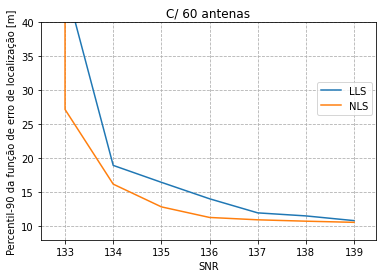

In [20]:
#PLOTs
label = ('LLS'); plt.plot(SNR,perc90l, label=label)
label = ('NLS'); plt.plot(SNR,perc90n, label=label)
plt.ylabel("Percentil-90 da função de erro de localização [m]"); plt.xlabel("SNR");
plt.ylim(top=40,bottom=8);plt.xlim(left=132.5)
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('C/ {} antenas'.format(n_rx)); plt.grid(linestyle='--')

LLS
 90-percentile for [-15 -10   0]dBm, respectively:
[12.88043044 10.71560855 10.69657246]m
NLS
 90-percentile for [-15 -10   0]dBm, respectively:
[10.71681662 10.49800384 10.49800384]m


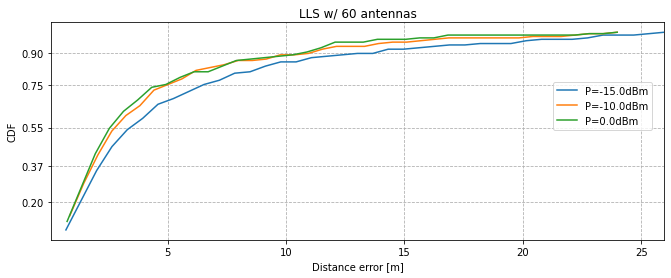

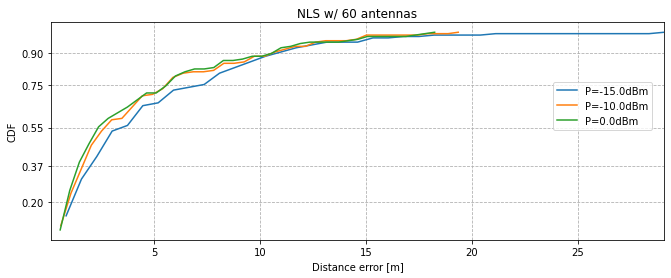

In [32]:
from scipy.io import savemat,loadmat

mc = 150
ruido_dbm = -127#dBm
n_ue = 1
#Carrier frequency
f0 = 5.8e9 #Hz
#User band
Δf = 120e3 #Hz
#Numero de portadoras (OFDM)
n_f = 600
#Spectral density of noise
N0=-127#dBm
N_bs = 4 #No of nearest BSs for computing distances on multilateration
#Array de antenas transmissoras e receptoras (mxn)
Mtx = 1; Ntx = 1;
Mrx = 10; Nrx = 6;
gap_bs = 10 #[m] Espaçamento entre cada BS 
MT_height = 1;
#Lados da area de bases (quadrado com bases a cada gap_bs metros)
BS,n_bs = bases(gap_bs, 40, 20,3)
UE = np.zeros([mc,n_ue,3])
P_db = np.array([-15,-10,0]); nPot = len(P_db)
perc90l = np.zeros(nPot); perc90n = np.zeros(nPot);#90 percentiles
#CDF values for plotting
cdf_errol=np.zeros([nPot,Nbins]); pdf_errol=np.zeros_like(cdf_errol); binsl=np.zeros([nPot,Nbins+1])
cdf_erron=np.zeros_like(cdf_errol); pdf_erron=np.zeros_like(cdf_errol); binsn=np.zeros_like(binsl);
#multi APs
n_tx = Mtx*Ntx #TX array
n_rx = Mrx*Nrx #RX array
c = 3e8

##
λmin = c/(f0+Δf*n_f/2)
d = λmin/2
v = steeringVector(n_rx,d,λmin,sweep_θ=18)
#Generating UEs for each MC realization
for l in range(mc):
    np.random.seed(l)
    UE[l] = usuário(n_ue, 40, 10,z_med=MT_height)
par = {'fc':f0, 'nSubcarr':n_f, 'freqSubcarr':Δf,'BS':BS, 'UE':UE, 'array':{'d':d,'Mtx':Mtx,'Ntx':Ntx,'Mrx':Mrx,'Nrx':Nrx}}
savemat("./models/mc_bf/parameters.mat",par)
# !!! It works only for Windows.
#For another OS, you must comment the line below and run the script manually ('.\scripts\genChannelModel_mc.m')
# ! .\octave_windows\mingw64\bin\octave-cli .\scripts\genChannelModel_mc_bf.m
H_mc,delay_real = loadChannel(mc,par,n_ue,path='./models/mc_bf/')
H_bf = np.zeros_like(H_mc[:,:,:,0,:])
for l in range(mc):
    UE_l = UE[l]
    H = H_mc[l]
    H_bf[l]=bf_filter(H,n_bs,n_ue,n_f,v)

#Computing results for each power
for i,p_db in enumerate(P_db):
    P = inv_dbm(p_db)/n_f
    erro_range_mc = np.zeros([mc])
    r_estl_mc = np.zeros([mc,n_ue,2],dtype='float64'); r_estn_mc = np.zeros([mc,n_ue,2],dtype='float64')
    D_est_mc = np.zeros([mc,n_ue,n_bs],dtype='float64');
    for l in range(mc):
        np.random.seed(l)
        r_l,r_n,D_est,D = calcDist_bf(H_bf[l],delay_real,n_bs,n_ue,n_f,P,Δf,ruido_dbm,N_bs=N_bs,NLS=True)
        #Erro de distancia BS_UEest (metros)
        erro_D = np.abs(D-D_est)
        #Erro de raio UEest_real (metros)        
        r_estl_mc[l] = r_l; r_estn_mc[l] = r_n
    cdf_errol[i],pdf_errol[i],binsl[i],perc90l[i] = cdf_erro(r_estl_mc,UE)
    cdf_erron[i],pdf_erron[i],binsn[i],perc90n[i] = cdf_erro(r_estn_mc,UE)

#LLS
print('LLS\n 90-percentile for {}dBm, respectively:'.format(P_db)); print('{}m'.format(perc90l))
plt.figure(figsize=(11,4))
for i,p_db in enumerate(P_db):
    label = ('P={}dBm'.format(np.trunc(p_db))) 
    plt.plot(binsl[i,1:],cdf_errol[i], label=label)
plt.ylabel("CDF"); plt.xlabel("Distance error [m]"); plt.yticks([0.2,0.37,0.55,0.75,0.9])
plt.xlim(np.min(binsl),np.min([np.max(binsl),40]))
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('LLS w/ {} antennas'.format(n_rx)); plt.grid(linestyle='--')
#NLS
print('NLS\n 90-percentile for {}dBm, respectively:'.format(P_db)); print('{}m'.format(perc90n))
plt.figure(figsize=(11,4))
for i,p_db in enumerate(P_db):
    label = ('P={}dBm'.format(np.trunc(p_db))) 
    plt.plot(binsn[i,1:],cdf_erron[i], label=label)
plt.ylabel("CDF"); plt.xlabel("Distance error [m]")
plt.yticks([0.2,0.37,0.55,0.75,0.9]); plt.xlim(np.min(binsn),np.min([np.max(binsn),40]))
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('NLS w/ {} antennas'.format(n_rx)); plt.grid(linestyle='--')

SNR

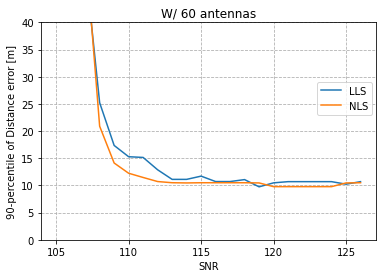

In [35]:
from scipy.io import savemat,loadmat

mc = 150
ruido_dbm = -127#Spectral density of noise [dBm]
n_ue = 1
#Carrier frequency
f0 = 5.8e9 #Hz
#User band
Δf = 120e3 #Hz
#Numero de portadoras (OFDM)
n_f = 600
#Spectral density of noise
# N0=-127#dBm
N_bs = 4 #No of nearest BSs for computing distances on multilateration
#Array de antenas transmissoras e receptoras (mxn)
Mtx = 1; Ntx = 1;
Mrx = 10; Nrx = 6;
gap_bs = 10 #[m] Espaçamento entre cada BS 
MT_height = 1;
#Lados da area de bases (quadrado com bases a cada gap_bs metros)
BS,n_bs = bases(gap_bs, 40, 20,3)
UE = np.zeros([mc,n_ue,3])
SNR = np.arange(105,127,1); nPot = len(SNR)
perc90l = np.zeros(nPot); perc90n = np.zeros(nPot);#90 percentiles
#CDF values for plotting
cdf_errol=np.zeros([nPot,Nbins]); pdf_errol=np.zeros_like(cdf_errol); binsl=np.zeros([nPot,Nbins+1])
cdf_erron=np.zeros_like(cdf_errol); pdf_erron=np.zeros_like(cdf_errol); binsn=np.zeros_like(binsl);
#multi APs
n_tx = Mtx*Ntx #TX array
n_rx = Mrx*Nrx #RX array
c = 3e8
λmin = c/(f0+Δf*n_f/2)
d = λmin/2
v = steeringVector(n_rx,d,λmin,sweep_θ=18)
##Generating UEs for each MC realization
# for l in range(mc):
#     np.random.seed(l)
#     UE[l] = usuário(n_ue, 40, 10,z_med=MT_height)
# par = {'fc':f0, 'nSubcarr':n_f, 'freqSubcarr':Δf,'BS':BS, 'UE':UE, 'array':{'d':d,'Mtx':Mtx,'Ntx':Ntx,'Mrx':Mrx,'Nrx':Nrx}}
# savemat("./models/mc_bf/parameters.mat",par)
## !!! It works only for Windows.
##For another OS, you must comment the line below and run the script manually ('.\scripts\genChannelModel_mc.m')
# ! .\octave_windows\mingw64\bin\octave-cli .\scripts\genChannelModel_mc_bf.m
H_mc,delay_real = loadChannel(mc,par,n_ue,path='./models/mc_bf/')
H_bf = np.zeros_like(H_mc[:,:,:,0,:])
for l in range(mc):
    UE_l = UE[l]
    H = H_mc[l]
    H_bf[l]=bf_filter(H,n_bs,n_ue,n_f,v)

#Computing results for each snr
for i,snr_db in enumerate(SNR):
    p_db = snr_db + ruido_dbm
    P = inv_dbm(p_db)/n_f
    erro_range_mc = np.zeros([mc])
    r_estl_mc = np.zeros([mc,n_ue,2],dtype='float64'); r_estn_mc = np.zeros([mc,n_ue,2],dtype='float64')
    D_est_mc = np.zeros([mc,n_ue,n_bs],dtype='float64');
    for l in range(mc):
        np.random.seed(l)
        r_l,r_n,D_est,D = calcDist_bf(H_bf[l],delay_real,n_bs,n_ue,n_f,P,Δf,ruido_dbm,N_bs=N_bs,NLS=True)
        #Erro de distancia BS_UEest (metros)
        erro_D = np.abs(D-D_est)
        #Erro de raio UEest_real (metros)        
        r_estl_mc[l] = r_l; r_estn_mc[l] = r_n
    perc90l[i] = cdf_erro(r_estl_mc,UE,hist=False); perc90n[i] = cdf_erro(r_estn_mc,UE,hist=False)
#PLOTs
label = ('LLS'); plt.plot(SNR,perc90l, label=label)
label = ('NLS'); plt.plot(SNR,perc90n, label=label)
plt.ylabel("90-percentile of Distance error [m]"); plt.xlabel("SNR"); #plt.yticks([0.2,0.37,0.55,0.75,0.9])
plt.ylim(top=40,bottom=0)
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('W/ {} antennas'.format(n_rx)); plt.grid(linestyle='--')

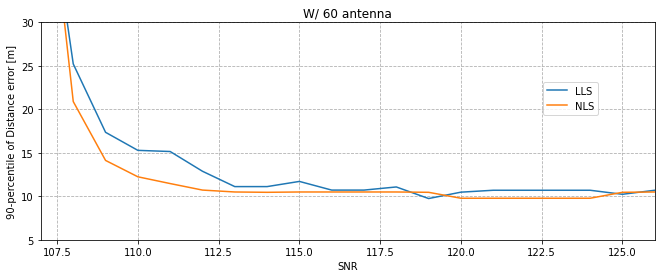

In [38]:
plt.figure(figsize=(11,4))
label = ('LLS'); plt.plot(SNR,perc90l, label=label)
label = ('NLS'); plt.plot(SNR,perc90n, label=label)
plt.ylabel("90-percentile of Distance error [m]"); plt.xlabel("SNR");
plt.ylim(top=30,bottom=5)
plt.xlim(left=107,right=126)
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.title('W/ {} antenna'.format(n_rx)); plt.grid(linestyle='--')

Variar número de portadoras